In [70]:
import numpy as np
import csv
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch

## Model Parameters
All the parameters are here. Non-modifiable parameters are about the Slice Window, and the Modifiable parameters are the GAT neural network parameters.

In [71]:
data_path = ["data/nodes.csv", "data/speed.npz"]
# Non-modifiable parameters
NUM_NODES = 21947
DIVIDE=[24, 7]
TIME_INTERVAL=1
HISTORY_LENGTH=24
# Modifiable parameters
N_HEADS=2
BATCH_SIZE = 2
LEARNING_RATE = 1e-3
EPOCH = 20

## Input data preparation
Divide the dataset into train_set and test_set. And load the data into data_loader

In [72]:
def get_adjacent_matrix(distance_file, num_nodes):
    # Construct the adjacency matrix for distance_file
    """
    :param distance_file: str, path of csv file to save the weight between nodes.
    :param num_nodes: int, number of nodes in the graph
    :return:
        np.array(N, N)
    """
    A = np.zeros([int(num_nodes), int(num_nodes)])

    with open(distance_file, "r") as f_d:
        f_d.readline()
        reader = csv.reader(f_d)
        for item in reader:
            i, j, distance = int(item[0]), int(item[1]), int(float(item[2]))
            A[i,j], A[j,i] = 1.0,1.0
    return A

In [73]:
def get_flow_data(flow_file):
    # This is to load the speed data, return the numpy multi-dimensional array
    """
    :param flow_file: str, path of .npz file to save the speed data
    :return:
        np.array
    """
    data = np.load(flow_file)
    flow_data = data["data"].transpose([1,0,2])[:,:,0][:,:,np.newaxis]
    return flow_data

In [74]:
def pre_porcess_data(data, norm_dim):
    # Data normalization
    """
    :param data: np.array,Raw traffic flow data
    :param norm_dim: int, Normalized dimensionality
    :return:
        norm_base: list, [max_data, min_data], Basement
        norm_data: np.array, normalized speed data.
    """
    norm_base = [np.max(data, norm_dim, keepdims=True), np.min(data, norm_dim, keepdims=True)]
    norm_data = (data - norm_base[1]) / (norm_base[0] - norm_base[1])
    return norm_base, norm_data

In [75]:
def slice_data(data, history_length, index, train_mode):
    # Dividing data samples according to historical length, subscripts
    """
    :param data: np.array, normalized speed data.
    :param history_length: int, length of history data to be used.
    :param index: int, index on temporal axis.
    :param train_mode: str, ["train", "test"].
    :return:
        data_x: np.array
        data_y: np.array
    """
    if train_mode == "train":
        start_index = index
        end_index = index + history_length
    elif train_mode == "test":
        start_index = index - history_length
        end_index = index
    else:
        raise ValueError("train model {} is not defined".format(train_mode))

    data_x = data[:, start_index:end_index]
    data_y = data[:, end_index]

    return data_x, data_y

In [76]:
class Data(Dataset):
    def __init__(self, flow_data, flow_norm, history_length, train_days,test_days , time_interval, graph,train_mode):
        """
        :param flow_data: np.array, normalized speed data.
        :param flow_norm: list, storage normalization parameters
        :param history_length: int, length of history data to be used.
        :param train_days: int, the day number of train dataset
        :param test_days: int, the day number of test dataset
        :param time_interval: int, time interval between two speed data records (1 hour)
        :param graph: np.array, adjacency matrix of graph data
        :param train_mode: list, ["train", "test"].
        """
        self.flow_data = flow_data
        self.flow_norm = flow_norm
        self.history_length = history_length
        self.train_days = train_days
        self.test_days = test_days
        self.one_day_length = int(24 * 1 / time_interval)
        self.graph = graph
        self.train_mode = train_mode

    def __len__(self): # Indicates the length of the data set
        """
        :return: length of dataset (number of samples).
        """
        if self.train_mode == "train":
            return self.train_days * self.one_day_length - self.history_length
        elif self.train_mode == "test":
            return self.test_days * self.one_day_length
        else:
            raise ValueError("train mode: [{}] is not defined".format(self.train_mode))

    def __getitem__(self, index):
        """
        :param index: int, range between [0, length - 1].
        :return:
            graph: torch.tensor
            data_x: torch.tensor
            data_y: torch.tensor
        """
        if self.train_mode == "train":
            index = index
        elif self.train_mode == "test":
            index += self.train_days * self.one_day_length # Offset Window
        else:
            raise ValueError("train mode: [{}] is not defined".format(self.train_mode))

        data_x, data_y = slice_data(self.flow_data,self.history_length, index, self.train_mode,)

        data_x = torch.tensor(data_x, dtype=torch.float)
        data_y = torch.tensor(data_y, dtype=torch.float).unsqueeze(1)
        graph_data = torch.tensor(self.graph,dtype=torch.float)

        return {"graph": graph_data, "flow_x": data_x, "flow_y": data_y}  # return as a dictionary


In [77]:
def recover_data(max_data, min_data, data):
    """
    :param max_data: np.array, max data.
    :param min_data: np.array, min data.
    :param data: np.array, normalized data.
    :return:
        recovered_data: np.array, recovered data.
    """
    mid = min_data
    base = max_data - min_data
    recovered_data = data * base + mid
    return recovered_data

In [78]:
def LoadData(data_path, num_nodes, divide_days, time_interval, history_length):
    train_days = divide_days[0]
    test_days = divide_days[1]

    graph = get_adjacent_matrix(data_path[0], num_nodes)
    flow_norm, flow_data = pre_porcess_data(get_flow_data(data_path[1]), norm_dim=1)

    train_data = Data(flow_data, flow_norm, history_length, train_days, test_days, time_interval, graph, train_mode="train")
    test_data = Data(flow_data, flow_norm, history_length, train_days, test_days, time_interval, graph, train_mode="test")

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, test_loader

In [79]:
train_loader, test_loader = LoadData(data_path=data_path, num_nodes=NUM_NODES, divide_days=DIVIDE
                                    ,time_interval=TIME_INTERVAL, history_length=HISTORY_LENGTH,)

print(len(train_loader))
print(len(test_loader))
print(train_loader.dataset[0]["flow_x"].size())
print(test_loader.dataset[0]["flow_x"].size())

276
84
torch.Size([21947, 24, 1])
torch.Size([21947, 24, 1])


## Model building
Constructing the GAT model

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import h5py
import time
import os

In [81]:
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_c, out_c):
        super(GraphAttentionLayer, self).__init__()
        self.in_c = in_c
        self.out_c = out_c
        self.F = F.softmax
        self.W = nn.Linear(in_c, out_c, bias=False)
        self.b = nn.Parameter(torch.Tensor(out_c))
        nn.init.normal_(self.W.weight)
        nn.init.normal_(self.b)

    def forward(self, inputs, graph):
        """
        :param inputs: input features,
        :param graph: graph structure,
        :return:
            output features
        """
        h = self.W(inputs)
        outputs = torch.bmm(h,h.transpose(1,2)) * graph.unsqueeze(0)
        outputs.data.masked_fill_(torch.eq(outputs, 0), -float(1e16))
        attention = self.F(outputs, dim=2)
        return torch.bmm(attention, h) + self.b

In [82]:
class GATSubNet(nn.Module):
    def __init__(self, in_c, hid_c, out_c, n_heads):
        super(GATSubNet, self).__init__()

        self.attention_module = nn.ModuleList([GraphAttentionLayer(in_c, hid_c) for _ in range(n_heads)])
        self.out_att = GraphAttentionLayer(hid_c * n_heads, out_c)
        self.act = nn.LeakyReLU()

    def forward(self, inputs, graph):
        """
        :param inputs: np.array, speed data
        :param graph: np.array, graph data
        :return: output result
        """
        outputs = torch.cat([attn(inputs, graph) for attn in self.attention_module], dim=-1)
        outputs = self.act(outputs)
        outputs = self.out_att(outputs,graph)
        return self.act(outputs)


In [83]:
class GATNet(nn.Module):
    def __init__(self, in_c, hid_c, out_c, n_heads):
        super(GATNet, self).__init__()
        self.subnet = GATSubNet(in_c, hid_c, out_c, n_heads)

    def forward(self, data, device):
        """
        :param data: data with speed and graph
        :param device: cuda
        :return: Prediction value
        """
        graph = data["graph"][0].to(device)
        flow = data["flow_x"]
        flow = flow.to(device)

        B,N = flow.size(0), flow.size(1)
        flow = flow.view(B, N, -1)

        prediction = self.subnet(flow, graph).unsqueeze(2)
        return prediction

## Run model
Integrate all codes and begin to train, calculate MAE, MAPE, RMSE on test dataset.

In [84]:
def main():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    train_loader, test_loader = LoadData(data_path, num_nodes=NUM_NODES, divide_days=DIVIDE,
                                         time_interval=TIME_INTERVAL, history_length=HISTORY_LENGTH)



    my_net = GATNet(in_c=24*1, hid_c=24, out_c=1, n_heads=N_HEADS) # Load GAT model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    my_net = my_net.to(device)

    criterion = nn.MSELoss() #MSE Loss

    optimizer = optim.Adam(params=my_net.parameters(), lr=LEARNING_RATE)
    Epoch = EPOCH

    my_net.train()
    for epoch in range(Epoch):
        epoch_loss = 0.0
        count = 0
        start_time = time.time()
        for data in train_loader:
            my_net.zero_grad()
            count += 1
            predict_value = my_net(data, device).to(torch.device("cpu"))
            loss = criterion(predict_value, data["flow_y"])
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        end_time = time.time()

        print("Epoch: {:04d}, Loss: {:02.4f}, Time: {:02.2f} mins".format(epoch, 1000 * epoch_loss / len(train_loader),
                                                                          (end_time - start_time) / 60))

    # Test Model
    my_net.eval()
    with torch.no_grad():
        MAE, MAPE, RMSE = [],[],[]
        Target = np.zeros([NUM_NODES, 1, 1])
        Predict = np.zeros_like(Target)

        total_loss = 0.0
        for data in test_loader:
            predict_value = my_net(data, device).to(torch.device("cpu"))
            loss = criterion(predict_value, data["flow_y"])
            total_loss += loss.item()
            predict_value = predict_value.transpose(0,2).squeeze(0)
            target_value = data["flow_y"].transpose(0,2).squeeze(0)

            try:
                dataset = test_loader.dataset
            except:
                dataset = test_loader

            prediction = recover_data(dataset.flow_norm[0], dataset.flow_norm[1], predict_value.numpy())
            target = recover_data(dataset.flow_norm[0], dataset.flow_norm[1], target_value.numpy())
            # mae, mape, rmse = Evaluation.total(target.reshape(-1), prediction.reshape(-1))
            mae = np.mean(np.abs(target.reshape(-1) - prediction.reshape(-1)))
            mape = np.mean(np.abs(target.reshape(-1) - prediction.reshape(-1)) / (target.reshape(-1) + 1))
            rmse = np.sqrt(np.mean(np.power(target.reshape(-1) - prediction.reshape(-1), 2)))

            MAE.append(mae)
            MAPE.append(mape)
            RMSE.append(rmse)

            Predict = np.concatenate([Predict, prediction], axis=1)
            Target = np.concatenate([Target,target], axis=1)

            print("Test Loss: {:02.4f}".format(1000 * total_loss / len(test_loader)))

    print("Performance:  MAE {:2.2f}    {:2.2f}%    {:2.2f}".format(np.mean(MAE), np.mean(MAPE), np.mean(RMSE)))
    Predict = np.delete(Predict, 0, axis=1)
    Target = np.delete(Target, 0, axis=1)

    result_file = "GAT_result.h5"
    file_obj = h5py.File(result_file, "w")

    file_obj["predict"] = Predict
    file_obj["target"] = Target

In [85]:
main()

Epoch: 0000, Loss: 594.7637, Time: 11.84 mins
Epoch: 0001, Loss: 498.6899, Time: 11.90 mins
Epoch: 0002, Loss: 436.7366, Time: 11.89 mins
Epoch: 0003, Loss: 355.6974, Time: 12.02 mins
Epoch: 0004, Loss: 287.1474, Time: 11.70 mins
Epoch: 0005, Loss: 226.3752, Time: 11.85 mins
Epoch: 0006, Loss: 175.9003, Time: 11.89 mins
Epoch: 0007, Loss: 146.5162, Time: 11.79 mins
Epoch: 0008, Loss: 131.9654, Time: 11.90 mins
Epoch: 0009, Loss: 119.7719, Time: 11.79 mins
Epoch: 0010, Loss: 110.8901, Time: 11.62 mins
Epoch: 0011, Loss: 103.8396, Time: 11.81 mins
Epoch: 0012, Loss: 99.1288, Time: 11.78 mins
Epoch: 0013, Loss: 96.1718, Time: 11.86 mins
Epoch: 0014, Loss: 92.8669, Time: 11.86 mins
Epoch: 0015, Loss: 89.6736, Time: 11.49 mins
Epoch: 0016, Loss: 90.3552, Time: 11.27 mins
Epoch: 0017, Loss: 89.0841, Time: 11.16 mins
Epoch: 0018, Loss: 86.5989, Time: 11.53 mins
Epoch: 0019, Loss: 83.7698, Time: 11.86 mins
Test Loss: 1.0373
Test Loss: 2.2348
Test Loss: 3.2949
Test Loss: 4.3963
Test Loss: 5.259

## Evaluation
Plot the comparison of predicted and actual values on the test set

In [86]:
import matplotlib.pyplot as plt

def visualize_result(h5_file, nodes_id, time_se, visualize_file):
    file_obj = h5py.File(h5_file, "r")
    prediction = file_obj["predict"][:][:, :, 0]  # [N, T]
    target = file_obj["target"][:][:, :, 0]  # [N, T]
    file_obj.close()

    plot_prediction = prediction[nodes_id][time_se[0]: time_se[1]]  # [T1]
    plot_target = target[nodes_id][time_se[0]: time_se[1]]  # [T1]

    plt.figure()
    plt.grid(True, linestyle="-.", linewidth=0.5)
    plt.plot(np.array([t for t in range(time_se[1] - time_se[0])]), plot_prediction, ls="-", marker=" ", color="r")
    plt.plot(np.array([t for t in range(time_se[1] - time_se[0])]), plot_target, ls="-", marker=" ", color="b")

    plt.legend(["prediction", "target"], loc="upper right")

    plt.axis([0, time_se[1] - time_se[0],
              np.min(np.array([np.min(plot_prediction), np.min(plot_target)])),
              np.max(np.array([np.max(plot_prediction), np.max(plot_target)]))])

    plt.savefig(visualize_file + ".png")
    plt.show()

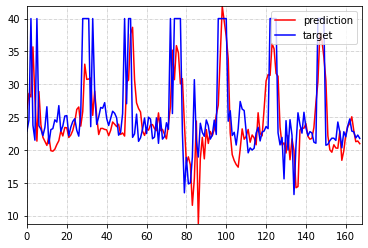

In [87]:
visualize_result(h5_file="GAT_result.h5",
                nodes_id=120,
                time_se=[0, 7*24],
                visualize_file="gat_node_120")